In [2]:
# 패키지 로드
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from collections import defaultdict
import os, random

from scipy import sparse
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.nn.init import normal_
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

In [3]:
# 경로 설정
data_path = '/Users/kyoungseo/lgupls_aistage/data/'
saved_path = '/Users/kyoungseo/lgupls_aistage/saved'
output_path = '/Users/kyoungseo/lgupls_aistage/submission'

In [4]:
# 데이터 불러오기 
history = pd.read_csv(os.path.join(data_path, 'history_data.csv'), encoding='utf-8')
watch = pd.read_csv(os.path.join(data_path, 'watch_e_data.csv'), encoding='utf-8')
buy = pd.read_csv(os.path.join(data_path, 'buy_data.csv'), encoding='utf-8') 
search = pd.read_csv(os.path.join(data_path, 'search_data.csv'), encoding='utf-8')
profile = pd.read_csv(os.path.join(data_path, 'profile_data.csv'), encoding='utf-8')
meta = pd.read_csv(os.path.join(data_path, 'meta_data.csv'), encoding='utf-8')
meta_plus = pd.read_csv(os.path.join(data_path, 'meta_data_plus.csv'), encoding='utf-8')

In [5]:
hd = history.copy()
wd = watch.copy()
bd = buy.copy()
sd = search.copy()
prd = profile.copy()
md = meta.copy()
mpd = meta_plus.copy()

In [6]:
print('hd 데이터(중복 제거 전) : ', hd.shape)
print('wd 데이터(중복 제거 전) : ', wd.shape)

hd 데이터(중복 제거 전) :  (1005651, 8)
wd 데이터(중복 제거 전) :  (892794, 8)


#### 1. 중복 데이터 제거

In [7]:
# 중복행 확인
hd[hd.duplicated()] # 시청시작 데이터

,profile_id,ss_id,log_time,act_target_dtl,album_id,payment,continuous_play,short_trailer
517,5,20220421082427,20220421082957,MKID003,92,NaN,N,N
519,5,20220421082427,20220421085009,MKID003,174,NaN,N,N
521,5,20220421082427,20220421090237,MKID003,201,NaN,N,N
523,5,20220421082427,20220421090332,MKID003,187,NaN,N,N
525,5,20220421082427,20220421090449,MKID003,305,NaN,N,N
...,...,...,...,...,...,...,...,...
1004498,32908,20220420203843,20220420204139,MKID003,6458,NaN,N,N
1005467,33015,20220424194027,20220424194036,MKID003,416,NaN,Y,N
1005469,33015,20220424194027,20220424194091,MKID003,175,NaN,N,Y
1005471,33015,20220424195608,20220424195612,MKID003,57,NaN,N,N


In [8]:
wd[wd.duplicated()] # 시청종료 데이터

,profile_id,ss_id,log_time,act_target_dtl,album_id,watch_time,total_time,continuous_play
507,5,20220421082427,20220421082953,MKID049,298,307,309,1
509,5,20220421082427,20220421085005,MKID049,92,1207,1207,1
511,5,20220421082427,20220421090233,MKID049,174,744,745,1
513,5,20220421082427,20220421090327,MKID049,201,50,50,1
515,5,20220421082427,20220421090443,MKID049,187,70,70,1
...,...,...,...,...,...,...,...,...
892571,33016,20220424194881,20220424195327,MKID049,5873,94,94,1
892573,33016,20220424194881,20220424195543,MKID049,5874,94,94,1
892575,33016,20220424194881,20220424195570,MKID049,5874,50,94,0
892577,33016,20220424194881,20220424195683,MKID049,4598,34,95,0


In [9]:
# 중복행 제거
hd = hd[~hd.duplicated()]
print('hd 데이터(중복 제거 후) : ', hd.shape)

wd = wd[~wd.duplicated()]
print('wd 데이터(중복 제거 후) : ', wd.shape)

hd 데이터(중복 제거 후) :  (899273, 8)
wd 데이터(중복 제거 후) :  (800740, 8)


#### 2. 이상치 제거

#### 2-1. History_data 내 log_time 이상치 제거

In [10]:
hd.head()

,profile_id,ss_id,log_time,act_target_dtl,album_id,payment,continuous_play,short_trailer
0,3,20220301115653,20220301115719,MKID003,15,NaN,Y,N
1,3,20220301115653,20220301115809,MKID003,16,NaN,Y,N
2,3,20220301115653,20220301115958,MKID003,17,NaN,Y,N
3,3,20220301115653,20220301120118,MKID003,18,NaN,Y,N
4,3,20220301115653,20220301120229,MKID003,19,NaN,Y,N


In [11]:
hd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 899273 entries, 0 to 1005650
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   profile_id       899273 non-null  int64  
 1   ss_id            899273 non-null  int64  
 2   log_time         899273 non-null  int64  
 3   act_target_dtl   899273 non-null  object 
 4   album_id         899273 non-null  int64  
 5   payment          59193 non-null   float64
 6   continuous_play  899273 non-null  object 
 7   short_trailer    899273 non-null  object 
dtypes: float64(1), int64(4), object(3)
memory usage: 61.7+ MB


In [12]:
# log_time 날짜/시간 분리
hd["log_time"] = hd["log_time"].astype(str)
hd["date"] = hd["log_time"].str.slice(0, 8)
hd["time"] = hd["log_time"].str.slice(8, 14)

In [13]:
hd.head()

,profile_id,ss_id,log_time,act_target_dtl,album_id,payment,continuous_play,short_trailer,date,time
0,3,20220301115653,20220301115719,MKID003,15,NaN,Y,N,20220301,115719
1,3,20220301115653,20220301115809,MKID003,16,NaN,Y,N,20220301,115809
2,3,20220301115653,20220301115958,MKID003,17,NaN,Y,N,20220301,115958
3,3,20220301115653,20220301120118,MKID003,18,NaN,Y,N,20220301,120118
4,3,20220301115653,20220301120229,MKID003,19,NaN,Y,N,20220301,120229


In [14]:
hd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 899273 entries, 0 to 1005650
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   profile_id       899273 non-null  int64  
 1   ss_id            899273 non-null  int64  
 2   log_time         899273 non-null  object 
 3   act_target_dtl   899273 non-null  object 
 4   album_id         899273 non-null  int64  
 5   payment          59193 non-null   float64
 6   continuous_play  899273 non-null  object 
 7   short_trailer    899273 non-null  object 
 8   date             899273 non-null  object 
 9   time             899273 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 75.5+ MB


In [15]:
# 월 조건 (3 ~ 7월 제외한 월이 있는지)
con1 = (hd['date'].str[4:6] != '03')
con2 = (hd['date'].str[4:6] != '04')
con3 = (hd['date'].str[4:6] != '05')
con4 = (hd['date'].str[4:6] != '06')
con5 = (hd['date'].str[4:6] != '07')

# 일 조건 (0일 / 00일 / 32일 이상 있는지)
con8 = (hd['date'].str[6:8] == '0')
con9 = (hd['date'].str[6:8] == '00')
con10 = (hd['date'].str[6:8].astype(int) >= 32)

In [16]:
print('조건에 맞지 않는 연도 수:', len(hd.loc[hd['date'].str[:4] != '2022']))
print('조건에 맞지 않는 월 수:', len(hd.loc[con1 & con2 & con3 & con4 & con5]))
print('조건에 맞지 않는 일 수:', len(hd.loc[con8 | con9 | con10]))

조건에 맞지 않는 연도 수: 0
조건에 맞지 않는 월 수: 0
조건에 맞지 않는 일 수: 0


In [17]:
print('조건에 맞지 않는 시 수:', len(hd.loc[hd['time'].str[:2] >= '24']))
print('조건에 맞지 않는 분 수:', len(hd.loc[hd['time'].str[2:4] >= '60']))
print('조건에 맞지 않는 초 수:', len(hd.loc[hd['time'].str[4:6] >= '60']))

조건에 맞지 않는 시 수: 0
조건에 맞지 않는 분 수: 0
조건에 맞지 않는 초 수: 73581


In [18]:
# 초에만 이상 있음
# 이상 있는 데이터 73,581개
hd.loc[hd['time'].str[4:6] >= '60']

,profile_id,ss_id,log_time,act_target_dtl,album_id,payment,continuous_play,short_trailer,date,time
2975,30,20220305130048,20220305131273,MKID003,1901,NaN,Y,N,20220305,131273
2976,30,20220305130048,20220305132966,MKID003,1902,NaN,Y,N,20220305,132966
2978,30,20220305130048,20220305134092,MKID003,1903,NaN,Y,N,20220305,134092
2983,30,20220320140092,20220320140174,MKID003,446,500.0,N,N,20220320,140174
2988,30,20220320140092,20220320144788,MKID003,1908,500.0,Y,N,20220320,144788
...,...,...,...,...,...,...,...,...,...,...
1005638,33032,20220427151499,20220427154870,MKID003,7105,NaN,N,N,20220427,154870
1005639,33032,20220427151499,20220427155075,MKID003,1725,NaN,Y,N,20220427,155075
1005646,33032,20220427155091,20220427155668,MKID003,381,NaN,Y,N,20220427,155668
1005647,33032,20220427155091,20220427155680,MKID003,381,NaN,Y,N,20220427,155680


In [19]:
# 이상 데이터 제거
hd = hd.drop(hd.loc[hd['time'].str[4:6] >= '60'].index)
print('이상 데이터 제거 후:', len(hd))

이상 데이터 제거 후: 825692


In [20]:
print('조건에 맞지 않는 초 수:', len(hd.loc[hd['time'].str[4:6] >= '60']))

조건에 맞지 않는 초 수: 0


In [21]:
hd = hd.drop(['date', 'time'], axis = 1)

In [22]:
# log_time type 다시 int형으로 변경
hd["log_time"] = hd["log_time"].astype(int)

OverflowError: Python int too large to convert to C long

#### 2-2. watch_data 내 log_time 이상치 제거

In [ ]:
# log_time 날짜/시간 분리
wd["log_time"] = wd["log_time"].astype(str)
wd["date"] = wd["log_time"].str.slice(0, 8)
wd["time"] = wd["log_time"].str.slice(8, 14)

In [ ]:
wd.head()

In [ ]:
wd.info()

In [ ]:
# 월 조건 (3 ~ 7월 제외한 월이 있는지)
con1 = (wd['date'].str[4:6] != '03')
con2 = (wd['date'].str[4:6] != '04')
con3 = (wd['date'].str[4:6] != '05')
con4 = (wd['date'].str[4:6] != '06')
con5 = (wd['date'].str[4:6] != '07')

# 일 조건 (0일 / 00일 / 32일 이상 있는지)
con8 = (wd['date'].str[6:8] == '0')
con9 = (wd['date'].str[6:8] == '00')
con10 = (wd['date'].str[6:8].astype(int) >= 32)

In [ ]:
print('조건에 맞지 않는 연도 수:', len(wd.loc[wd['date'].str[:4] != '2022']))
print('조건에 맞지 않는 월 수:', len(wd.loc[con1 & con2 & con3 & con4 & con5]))
print('조건에 맞지 않는 일 수:', len(wd.loc[con8 | con9 | con10]))

In [ ]:
print('조건에 맞지 않는 시 수:', len(wd.loc[wd['time'].str[:2] >= '24']))
print('조건에 맞지 않는 분 수:', len(wd.loc[wd['time'].str[2:4] >= '60']))
print('조건에 맞지 않는 초 수:', len(wd.loc[wd['time'].str[4:6] >= '60']))

In [ ]:
# 초에만 이상 있음
# 이상 있는 데이터 61,392개
wd.loc[wd['time'].str[4:6] >= '60']

In [ ]:
# 이상 데이터 제거
wd = wd.drop(wd.loc[wd['time'].str[4:6] >= '60'].index)
print('이상 데이터 제거 후:', len(wd))

In [ ]:
print('조건에 맞지 않는 초 수:', len(wd.loc[wd['time'].str[4:6] >= '60']))

In [ ]:
wd = wd.drop(['date', 'time'], axis = 1)

In [ ]:
# log_time type 다시 int형으로 변경
wd["log_time"] = wd["log_time"].astype(int)

#### 3. profile data 결측값 처리

In [30]:
prd.head()

,profile_id,sex,age,pr_interest_keyword_cd_1,pr_interest_keyword_cd_2,pr_interest_keyword_cd_3,ch_interest_keyword_cd_1,ch_interest_keyword_cd_2,ch_interest_keyword_cd_3
0,3,F,5,P02,P04,P07,K01,K03,K04
1,5,M,5,P07,P08,P06,K05,K08,K09
2,7,F,9,P05,P03,NaN,K06,K04,NaN
3,12,M,6,P03,P06,P02,K09,K07,K03
4,16,F,12,P03,P06,P01,K01,K06,K04


In [31]:
prd.shape

(8311, 9)

In [85]:
prd.isnull().sum()

profile_id                     0
sex                            0
age                            0
pr_interest_keyword_cd_1       0
pr_interest_keyword_cd_2    1533
pr_interest_keyword_cd_3    2080
ch_interest_keyword_cd_1       0
ch_interest_keyword_cd_2    1693
ch_interest_keyword_cd_3    2282
dtype: int64

* 결측값 있는 column<br>

1) pr_interest_keyword_cd_2(부모 관심 키워드2): 1533<br>
2) pr_interest_keyword_cd_3(부모 관심 키워드3): 2080<br>
3) ch_interest_keyword_cd_2(아이 관심 키워드2): 1693<br>
4) ch_interest_keyword_cd_3(아이 관심 키워드3): 2282<br>

In [193]:
profile = pd.read_csv(os.path.join(data_path, 'profile_data.csv'), encoding='utf-8')
prd = profile.copy()

#### 3-1. 결측값 채우기1: 가장 선호도 높은 키워드로 채우기

In [135]:
pr_1 = prd['pr_interest_keyword_cd_1'].value_counts()
pr_2 = prd['pr_interest_keyword_cd_2'].value_counts()
pr_3 = prd['pr_interest_keyword_cd_3'].value_counts()
ch_1 = prd['ch_interest_keyword_cd_1'].value_counts()
ch_2 = prd['ch_interest_keyword_cd_2'].value_counts()
ch_3 = prd['ch_interest_keyword_cd_3'].value_counts()

In [136]:
print("부모 키워드1 최대 관심 키워드:", pr_1.index[0]) # 음악예술
print("부모 키워드2 최대 관심 키워드:", pr_2.index[0]) # 음악예술
print("부모 키워드3 최대 관심 키워드:", pr_3.index[0]) # 언어논리
print("아이 키워드1 최대 관심 키워드:", ch_1.index[0]) # 노래/율동
print("아이 키워드2 최대 관심 키워드:", ch_2.index[0]) # 동물/식물
print("아이 키워드3 최대 관심 키워드:", ch_3.index[0]) # 동화

부모 키워드1 최대 관심 키워드: P06
부모 키워드2 최대 관심 키워드: P06
부모 키워드3 최대 관심 키워드: P07
아이 키워드1 최대 관심 키워드: K01
아이 키워드2 최대 관심 키워드: K02
아이 키워드3 최대 관심 키워드: K03


In [149]:
prd.head(10)

,profile_id,sex,age,pr_interest_keyword_cd_1,pr_interest_keyword_cd_2,pr_interest_keyword_cd_3,ch_interest_keyword_cd_1,ch_interest_keyword_cd_2,ch_interest_keyword_cd_3
0,3,F,5,P02,P04,P07,K01,K03,K04
1,5,M,5,P07,P08,P06,K05,K08,K09
2,7,F,9,P05,P03,NaN,K06,K04,NaN
3,12,M,6,P03,P06,P02,K09,K07,K03
4,16,F,12,P03,P06,P01,K01,K06,K04
5,19,M,3,P05,P06,P04,K01,K08,K09
6,20,M,7,P07,P08,P03,K07,K01,K08
7,22,F,4,P06,NaN,NaN,K01,NaN,NaN
8,24,M,5,P05,P04,P07,K09,K01,K02
9,26,M,7,P01,P07,P03,K02,K06,K08


In [152]:
# pr_2는 P06, pr_3는 P07 / ch_2는 K02, ch_3는 K03으로 채우기
prd['pr_interest_keyword_cd_2'] = prd['pr_interest_keyword_cd_2'].fillna('P06')
prd['pr_interest_keyword_cd_3'] = prd['pr_interest_keyword_cd_3'].fillna('P07')
prd['ch_interest_keyword_cd_2'] = prd['ch_interest_keyword_cd_2'].fillna('K02')
prd['ch_interest_keyword_cd_3'] = prd['ch_interest_keyword_cd_3'].fillna('K03')

In [153]:
prd.head(10)

,profile_id,sex,age,pr_interest_keyword_cd_1,pr_interest_keyword_cd_2,pr_interest_keyword_cd_3,ch_interest_keyword_cd_1,ch_interest_keyword_cd_2,ch_interest_keyword_cd_3
0,3,F,5,P02,P04,P07,K01,K03,K04
1,5,M,5,P07,P08,P06,K05,K08,K09
2,7,F,9,P05,P03,P07,K06,K04,K03
3,12,M,6,P03,P06,P02,K09,K07,K03
4,16,F,12,P03,P06,P01,K01,K06,K04
5,19,M,3,P05,P06,P04,K01,K08,K09
6,20,M,7,P07,P08,P03,K07,K01,K08
7,22,F,4,P06,P06,P07,K01,K02,K03
8,24,M,5,P05,P04,P07,K09,K01,K02
9,26,M,7,P01,P07,P03,K02,K06,K08


In [155]:
prd.isnull().sum()

profile_id                  0
sex                         0
age                         0
pr_interest_keyword_cd_1    0
pr_interest_keyword_cd_2    0
pr_interest_keyword_cd_3    0
ch_interest_keyword_cd_1    0
ch_interest_keyword_cd_2    0
ch_interest_keyword_cd_3    0
dtype: int64

#### 3-2. 결측값 채우기2: 키워드1과 동일한 값 2,3에 채우기

In [ ]:
prd['pr_interest_keyword_cd_2'] = prd['pr_interest_keyword_cd_2'].fillna(prd['pr_interest_keyword_cd_1'])
prd['pr_interest_keyword_cd_3'] = prd['pr_interest_keyword_cd_3'].fillna(prd['pr_interest_keyword_cd_1'])
prd['ch_interest_keyword_cd_2'] = prd['ch_interest_keyword_cd_2'].fillna(prd['ch_interest_keyword_cd_1'])
prd['ch_interest_keyword_cd_3'] = prd['ch_interest_keyword_cd_3'].fillna(prd['ch_interest_keyword_cd_1'])

In [ ]:
prd.head(10)

In [ ]:
prd.isnull().sum()

#### 4. 범주형 데이터: 인코딩 정리

https://suy379.tistory.com/157<br>
https://jimmy-ai.tistory.com/263

#### 4-1. history data

In [ ]:
hd.head()

- continuous_play, short_trailer: 이진변수
- 0, 1로 변경


* continuous_play
    - 연속재생x: 0
    - 연속재생o: 1
    
    
* short_trailer
    - N: 0
    - Y: 1

In [ ]:
hd.loc[hd['short_trailer'] == 'Y']

In [ ]:
hd.loc[hd['short_trailer'] == 'N']

In [ ]:
hd['short_trailer'] = hd['short_trailer'].apply(lambda x: 1 if x == 'Y' else 0)

In [ ]:
hd.loc[hd['short_trailer'] == 1]

In [ ]:
hd.loc[hd['short_trailer'] == 0]

#### 4-2. profile data

- one-hot encoding 적용

In [ ]:
prd.head(15)

In [ ]:
prd.shape

* 범주형 데이터
    
    1) sex<br>
    2) pr_interest_keyword_cd_1<br>
    3) pr_interest_keyword_cd_2<br>
    4) pr_interest_keyword_cd_3<br>
    5) ch_interest_keyword_cd_1<br>
    6) ch_interest_keyword_cd_2<br>
    7) ch_interest_keyword_cd_3

In [ ]:
prd = pd.get_dummies(prd)

prd

In [ ]:
prd.shape

#### 5. log_time 파생변수 생성

- 6시간 기준으로 나누기

- 참고문헌<br>
- 2개 이상의 조건이 있을 때<br>
https://www.delftstack.com/ko/howto/python-pandas/how-to-create-dataframe-column-based-on-given-condition-in-pandas/

- 새로운 변수 생성<br>
1) 00_06: log_time이 00-06시 사이<br>
2) 06_12: log_time이 06-12시 사이<br>
3) 12_18: log_time이 12-18시 사이<br>
4) 18_24: log_time이 18-24시 사이

#### 5-1. history data

In [23]:
# log_time에서 시간만 분리
hd["log_time"] = hd["log_time"].astype(str)
hd["time"] = hd["log_time"].str[8:10].astype(int)

In [24]:
conditionlist = [
    (hd['time'] < 6) ,
    (hd['time'] >= 6) & (hd['time'] < 12),
    (hd['time'] >= 12) & (hd['time'] < 18),
    (hd['time'] >= 18) & (hd['time'] < 24)]
choicelist = [1, 2, 3, 4]
hd['time_slot'] = np.select(conditionlist, choicelist)

In [25]:
hd.head(10)

,profile_id,ss_id,log_time,act_target_dtl,album_id,payment,continuous_play,short_trailer,time,time_slot
0,3,20220301115653,20220301115719,MKID003,15,NaN,Y,N,11,2
1,3,20220301115653,20220301115809,MKID003,16,NaN,Y,N,11,2
2,3,20220301115653,20220301115958,MKID003,17,NaN,Y,N,11,2
3,3,20220301115653,20220301120118,MKID003,18,NaN,Y,N,12,3
4,3,20220301115653,20220301120229,MKID003,19,NaN,Y,N,12,3
5,3,20220301115653,20220301120450,MKID003,20,NaN,Y,N,12,3
6,3,20220301115653,20220301120654,MKID003,21,NaN,Y,N,12,3
7,3,20220301115653,20220301120859,MKID003,22,NaN,Y,N,12,3
8,3,20220301115653,20220301121104,MKID003,23,NaN,Y,N,12,3
9,3,20220301115653,20220301121308,MKID003,24,NaN,Y,N,12,3


In [26]:
hd.tail(10)

,profile_id,ss_id,log_time,act_target_dtl,album_id,payment,continuous_play,short_trailer,time,time_slot
1005635,33032,20220427151499,20220427154709,MKID003,7105,NaN,N,N,15,3
1005636,33032,20220427151499,20220427154710,MKID003,2297,NaN,Y,N,15,3
1005640,33032,20220427155091,20220427155532,MKID003,125,NaN,Y,N,15,3
1005641,33032,20220427155091,20220427155559,MKID003,381,NaN,N,N,15,3
1005642,33032,20220427155091,20220427155559,MKID003,375,NaN,Y,N,15,3
1005643,33032,20220427155091,20220427155601,MKID003,381,NaN,Y,N,15,3
1005644,33032,20220427155091,20220427155611,MKID003,381,NaN,Y,N,15,3
1005645,33032,20220427155091,20220427155642,MKID003,381,NaN,N,N,15,3
1005648,33032,20220427155839,20220427155810,MKID003,125,NaN,Y,N,15,3
1005649,33032,20220427155706,20220427155838,MKID003,125,NaN,Y,N,15,3


In [27]:
# time열 drop
hd = hd.drop(['time'], axis = 1)
hd.head()

,profile_id,ss_id,log_time,act_target_dtl,album_id,payment,continuous_play,short_trailer,time_slot
0,3,20220301115653,20220301115719,MKID003,15,NaN,Y,N,2
1,3,20220301115653,20220301115809,MKID003,16,NaN,Y,N,2
2,3,20220301115653,20220301115958,MKID003,17,NaN,Y,N,2
3,3,20220301115653,20220301120118,MKID003,18,NaN,Y,N,3
4,3,20220301115653,20220301120229,MKID003,19,NaN,Y,N,3


#### 5-2. watch data

In [28]:
# log_time에서 시간만 분리
wd["log_time"] = wd["log_time"].astype(str)
wd["time"] = wd["log_time"].str[8:10].astype(int)

In [29]:
conditionlist = [
    (wd['time'] < 6) ,
    (wd['time'] >= 6) & (wd['time'] < 12),
    (wd['time'] >= 12) & (wd['time'] < 18),
    (wd['time'] >= 18) & (wd['time'] < 24)]
choicelist = [1, 2, 3, 4]
wd['time_slot'] = np.select(conditionlist, choicelist)

In [30]:
wd.head(10)

,profile_id,ss_id,log_time,act_target_dtl,album_id,watch_time,total_time,continuous_play,time,time_slot
0,3,20220301115653,20220301115805,MKID049,15,46,46,1,11,2
1,3,20220301115653,20220301115954,MKID049,16,104,105,1,11,2
2,3,20220301115653,20220301120114,MKID049,17,76,76,1,12,3
3,3,20220301115653,20220301120226,MKID049,18,67,68,1,12,3
4,3,20220301115653,20220301120400,MKID049,19,90,90,0,12,3
5,3,20220301115653,20220301120650,MKID049,20,119,119,1,12,3
6,3,20220301115653,20220301120854,MKID049,21,119,119,1,12,3
7,3,20220301115653,20220301121059,MKID049,22,119,119,1,12,3
8,3,20220301115653,20220301121304,MKID049,23,120,121,1,12,3
9,3,20220301115653,20220301121508,MKID049,24,119,119,1,12,3


In [31]:
wd.tail(10)

,profile_id,ss_id,log_time,act_target_dtl,album_id,watch_time,total_time,continuous_play,time,time_slot
892784,33032,20220427155091,20220427155529,MKID049,381,462,463,1,15,3
892785,33032,20220427155091,20220427155601,MKID049,381,462,463,1,15,3
892786,33032,20220427155091,20220427155603,MKID049,125,6,520,0,15,3
892787,33032,20220427155091,20220427155646,MKID049,381,462,463,1,15,3
892788,33032,20220427155091,20220427155648,MKID049,381,463,464,1,15,3
892789,33032,20220427155091,20220427155653,MKID049,381,463,464,1,15,3
892790,33032,20220427155091,20220427155694,MKID049,381,462,463,1,15,3
892791,33032,20220427155839,20220427155826,MKID049,125,10,520,0,15,3
892792,33032,20220427155706,20220427155836,MKID049,125,6,521,0,15,3
892793,33032,20220427155839,20220427155897,MKID049,381,462,464,1,15,3


In [32]:
# time열 drop
wd = wd.drop(['time'], axis = 1)
wd.head()

,profile_id,ss_id,log_time,act_target_dtl,album_id,watch_time,total_time,continuous_play,time_slot
0,3,20220301115653,20220301115805,MKID049,15,46,46,1,2
1,3,20220301115653,20220301115954,MKID049,16,104,105,1,2
2,3,20220301115653,20220301120114,MKID049,17,76,76,1,3
3,3,20220301115653,20220301120226,MKID049,18,67,68,1,3
4,3,20220301115653,20220301120400,MKID049,19,90,90,0,3


#### 6. meta data

In [131]:
import matplotlib.pyplot as plt
plt.rc('font', family = 'Malgun Gothic')
plt.rc('axes', unicode_minus = False)

# 그래프가 노트북 안에 보이게 하기 위해
%matplotlib inline

In [104]:
md.head()

,album_id,title,sub_title,genre_large,genre_mid,genre_small,country,run_time,onair_date,cast_1,cast_2,cast_3,cast_4,cast_5,cast_6,cast_7
0,749,어둠이 무서워요,꼬마버스 타요1,키즈,TV만화,NaN,한국,660,NaN,타요,로기,라니,가니,시투,NaN,NaN
1,750,우리는 친구,꼬마버스 타요1,키즈,TV만화,NaN,한국,660,NaN,타요,로기,라니,가니,시투,NaN,NaN
2,2131,타요의 첫 운행,꼬마버스 타요1,키즈,TV만화,NaN,한국,660,NaN,타요,로기,라니,가니,시투,NaN,NaN
3,2625,길 잃은 타요,꼬마버스 타요1,키즈,TV만화,NaN,한국,660,NaN,타요,로기,라니,가니,시투,NaN,NaN
4,2594,새내기 꼬마 버스의 하루,꼬마버스 타요1,키즈,TV만화,NaN,한국,660,NaN,타요,로기,라니,가니,시투,NaN,NaN


In [106]:
md.shape

(42602, 16)

In [107]:
print('album_id 수:', md.album_id.nunique())
print('title 수:', md.title.nunique())
print('sub_title 수:', md.sub_title.nunique())

album_id 수: 39875
title 수: 36185
sub_title 수: 2373


In [115]:
md.isnull().sum()

album_id           0
title              0
sub_title          0
genre_large        0
genre_mid          0
genre_small    29183
country         8868
run_time           0
onair_date     37258
cast_1         14999
cast_2         20554
cast_3         26139
cast_4         30117
cast_5         36220
cast_6         39993
cast_7         41840
dtype: int64

In [109]:
md.genre_large.value_counts()

키즈     40224
애니      1991
방송       295
다큐        58
라이프       21
영화        13
Name: genre_large, dtype: int64

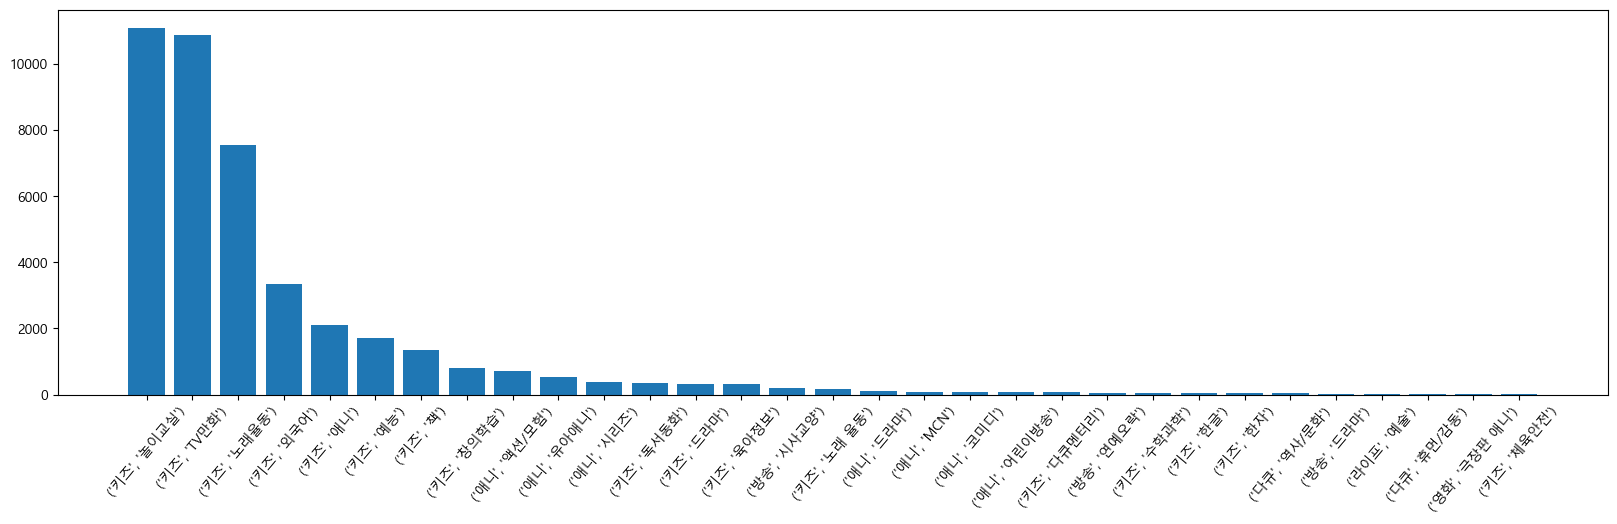

In [134]:
# genre_large, genre_mid 병합 
a = md.groupby('genre_large').genre_mid.value_counts().sort_values(ascending=False)
plt.figure(figsize = (20, 5))
plt.xticks(rotation = 50)
plt.bar([str(i) for i in list(a.index)], list(a))
plt.show()

In [150]:
md['title'].value_counts()

똑딱똑딱               104
동물일기                78
막이래쇼                45
막이래쇼 6: 무작정여행단      39
또봇 애슬론 스페셜          28
                  ... 
오리처럼 뒤뚱뒤뚱            1
우리는 콩콩이              1
개구리처럼 뛰어 볼까 폴짝!      1
작아져라 커져라             1
잃어버린 책               1
Name: title, Length: 36185, dtype: int64

- title, sub_tile 전부 같은데 album_id 다른 경우
- title, sub_tile 다른데 album_id 같은 경우...왜그러지...?

In [35]:
md.loc[md['title'] == '똑딱똑딱'][:5]

,album_id,title,sub_title,genre_large,genre_mid,genre_small,country,run_time,onair_date,cast_1,cast_2,cast_3,cast_4,cast_5,cast_6,cast_7
31514,18834,똑딱똑딱,똑딱똑딱,키즈,놀이교실,NaN,벨기에,314,NaN,소년,소녀,카멜레온,NaN,NaN,NaN,NaN
31515,18835,똑딱똑딱,똑딱똑딱,키즈,놀이교실,NaN,벨기에,314,NaN,소년,소녀,카멜레온,NaN,NaN,NaN,NaN
31516,18823,똑딱똑딱,똑딱똑딱,키즈,놀이교실,NaN,벨기에,314,NaN,소년,소녀,카멜레온,NaN,NaN,NaN,NaN
31517,18824,똑딱똑딱,똑딱똑딱,키즈,놀이교실,NaN,벨기에,314,NaN,소년,소녀,카멜레온,NaN,NaN,NaN,NaN
31518,18825,똑딱똑딱,똑딱똑딱,키즈,놀이교실,NaN,벨기에,314,NaN,소년,소녀,카멜레온,NaN,NaN,NaN,NaN


In [155]:
md.loc[md['title'] == '동물일기'][:5]

,album_id,title,sub_title,genre_large,genre_mid,genre_small,country,run_time,onair_date,cast_1,cast_2,cast_3,cast_4,cast_5,cast_6,cast_7
1314,2067,동물일기,동물일기,키즈,놀이교실,수학과학,저지,1585,20110303.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1327,19817,동물일기,동물일기,키즈,놀이교실,수학과학,저지,1646,20110310.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1335,26834,동물일기,동물일기,키즈,놀이교실,수학과학,저지,1605,20110317.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1343,26838,동물일기,동물일기,키즈,놀이교실,수학과학,저지,1652,20110324.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1382,26868,동물일기,동물일기,키즈,놀이교실,수학과학,저지,1708,20110403.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [154]:
md.loc[md['album_id'] == 8231]

,album_id,title,sub_title,genre_large,genre_mid,genre_small,country,run_time,onair_date,cast_1,cast_2,cast_3,cast_4,cast_5,cast_6,cast_7
13526,8231,알록달록 물고기,노래율동,키즈,노래율동,NaN,한국,64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13527,8231,알록달록 물고기,만 3세를 위한 영상,키즈,노래율동,NaN,한국,64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13528,8231,알록달록 물고기,만 4세를 위한 영상,키즈,노래율동,NaN,한국,64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13529,8231,알록달록 물고기,트니트니 율동 바다스페셜,키즈,노래율동,NaN,한국,64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [157]:
md.loc[md['album_id'] == 4083]

,album_id,title,sub_title,genre_large,genre_mid,genre_small,country,run_time,onair_date,cast_1,cast_2,cast_3,cast_4,cast_5,cast_6,cast_7
7904,4083,나비의 왈츠,개구리야 안녕?,키즈,노래율동,NaN,NaN,74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7905,4083,나비의 왈츠,노래율동,키즈,노래율동,NaN,NaN,74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7906,4083,나비의 왈츠,만 3세를 위한 영상,키즈,노래율동,NaN,NaN,74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7907,4083,나비의 왈츠,핑크퐁 곤충동요,키즈,노래율동,NaN,NaN,74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 7. meta data plus

In [158]:
mpd.head()

,album_id,keyword_type,keyword_name,keyword_value
0,749,05010101,시리즈,0
1,749,05010302,EBS,0
2,749,05010401,3세,0
3,749,05010402,4세,0
4,749,05010407,1세,0


In [162]:
md.loc[md['album_id'] == 4083]

,album_id,title,sub_title,genre_large,genre_mid,genre_small,country,run_time,onair_date,cast_1,cast_2,cast_3,cast_4,cast_5,cast_6,cast_7
7904,4083,나비의 왈츠,개구리야 안녕?,키즈,노래율동,NaN,NaN,74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7905,4083,나비의 왈츠,노래율동,키즈,노래율동,NaN,NaN,74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7906,4083,나비의 왈츠,만 3세를 위한 영상,키즈,노래율동,NaN,NaN,74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7907,4083,나비의 왈츠,핑크퐁 곤충동요,키즈,노래율동,NaN,NaN,74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [168]:
mpd.loc[mpd['album_id'] == 4083]

,album_id,keyword_type,keyword_name,keyword_value
142851,4083,05010101,시리즈,0
142852,4083,05010201,2분 미만,0
142853,4083,05010401,3세,0
142854,4083,05010407,1세,0
142855,4083,05010408,2세,0
142856,4083,0501080d,핑크퐁,0
142857,4083,05020203,엔터,0
142858,4083,05020205,노래,5
142859,4083,05030704,음악,0
142860,4083,05030705,동요,5


In [169]:
mpd.loc[mpd['keyword_type'] == '05010101']

,album_id,keyword_type,keyword_name,keyword_value
0,749,05010101,시리즈,0
21,750,05010101,시리즈,0
42,2131,05010101,시리즈,0
65,2625,05010101,시리즈,0
85,2594,05010101,시리즈,0
...,...,...,...,...
767892,39871,05010101,시리즈,0
767899,39872,05010101,시리즈,0
767906,39873,05010101,시리즈,0
767913,39874,05010101,시리즈,0


In [170]:
mpd.loc[mpd['keyword_name'] == '시리즈'] # keyword_type, keyword_name 둘 중 하나 지워도 될 듯

,album_id,keyword_type,keyword_name,keyword_value
0,749,05010101,시리즈,0
21,750,05010101,시리즈,0
42,2131,05010101,시리즈,0
65,2625,05010101,시리즈,0
85,2594,05010101,시리즈,0
...,...,...,...,...
767892,39871,05010101,시리즈,0
767899,39872,05010101,시리즈,0
767906,39873,05010101,시리즈,0
767913,39874,05010101,시리즈,0


In [171]:
mpd.keyword_value.value_counts()

0    602222
5    104849
3     37086
4     23679
1       101
2        11
Name: keyword_value, dtype: int64

In [173]:
mpd.loc[mpd['keyword_value'] == 5]

,album_id,keyword_type,keyword_name,keyword_value
7,749,05020201,스토리 애니,5
11,749,0508042c,타요,5
14,749,0508050a,버스,5
28,750,05020201,스토리 애니,5
34,750,0508042c,타요,5
...,...,...,...,...
767917,39874,05030702,그림그리기/색칠하기,5
767928,4779,05020204,동화,5
767929,4779,05030604,창작동화,5
767938,11629,05020205,노래,5


In [192]:
mpd.groupby('keyword_name').keyword_value.value_counts().sort_values(ascending=False)[:10]

keyword_name  keyword_value
시리즈           0                32644
엔터            0                30033
사회정서          0                26135
언어1           0                23611
TV 방영         0                16553
2분 이상 10분 미만  0                14018
4세            0                12920
스토리 애니        5                12481
5세            0                12142
자연탐구          0                11627
Name: keyword_value, dtype: int64

In [180]:
len(mpd.loc[(mpd['keyword_name'] == '시리즈') & (mpd['keyword_value'] != 0)]) 
# keyword_name이 시리즈면 key_word value 전부 0

0

In [183]:
mpd.loc[(mpd['keyword_name'] == '엔터') & (mpd['keyword_value'] != 0)]

,album_id,keyword_type,keyword_name,keyword_value
647991,9573,05020203,엔터,5
648000,8051,05020203,엔터,5
648009,9556,05020203,엔터,5
648018,9557,05020203,엔터,5
648140,9548,05020203,엔터,5
648149,9549,05020203,엔터,5
648158,16201,05020203,엔터,5


In [186]:
len(mpd.loc[(mpd['keyword_name'] == '사회정서') & (mpd['keyword_value'] != 0)])

0

In [189]:
len(mpd.loc[(mpd['keyword_name'] == '언어1') & (mpd['keyword_value'] != 0)])

0

In [190]:
len(mpd.loc[(mpd['keyword_name'] == 'TV 방영') & (mpd['keyword_value'] != 0)])

0

In [198]:
len(mpd.loc[(mpd['keyword_name'] == '스토리 애니') & (mpd['keyword_value'] == 5)])

12481

#### 7. 변수선택

In [ ]:
# target(Price)와 가장 correlated 된 features 를 k개 고르기.
## f_regresison, SelectKBest 불러오기.
from sklearn.feature_selection import f_regression, SelectKBest
## selctor 정의하기.
selector = SelectKBest(score_func=f_regression, k=20)
## 학습데이터에 fit_transform 
X_train_selected = selector.fit_transform(X_train, y_train)
## 테스트 데이터는 transform
X_test_selected = selector.transform(X_test)
X_train_selected.shape, X_test_selected.shape

In [ ]:
all_names = X_train.columns
## selector.get_support()
selected_mask = selector.get_support()
## 선택된 특성(변수)들
selected_names = all_names[selected_mask]
## 선택되지 않은 특성(변수)들
unselected_names = all_names[~selected_mask]
print('Selected names: ', selected_names)
print('Unselected names: ', unselected_names)

https://dyddl1993.tistory.com/18

In [200]:
from sklearn.feature_selection import VarianceThreshold